# Example: OOI Profiler Data

In order to use the OOI utility functions, you first need to put your OOI API credentials in a .netrc file in your home directory. The .netrc entry should look like this:

```
machine ooinet.oceanobservatories.org
login <your_ooi_username>
password <your_ooi_token>
```


The Ocean Observatories Initiative has provided the ACS Spectrophotometer with the generic name of OPTAA (Optical Absorption and Attenuation). Currently, OPTAAC, OPTAAD, and OPTAAJ are the deployment types for the sensor. The only difference between the C, D, and J variants are the deployment types and the housing depth limitations. They all produce the same data and would effectively use acpype in the same fashion. OPTAAC and OPTAAD indicate that the ACS is located at fixed depth on a fixed location platform. OPTAAJ denotes that the sensor is located on a profiler.

In this example, we will use OPTAAJ data from the Oregon Shelf Surface Piercing Profiler (CE02SHSP) Deployment 13. The data in this example was manually downloaded from the OOI GoldCopy Catalog, which contains the most up-to-date versions of OOI data.
https://thredds.dataexplorer.oceanobservatories.org/thredds/catalog/ooigoldcopy/public/CE02SHSP-SP001-04-OPTAAJ000-recovered_cspp-optaa_dj_cspp_instrument_recovered/catalog.html?dataset=ooigoldcopy/public/CE02SHSP-SP001-04-OPTAAJ000-recovered_cspp-optaa_dj_cspp_instrument_recovered/deployment0013_CE02SHSP-SP001-04-OPTAAJ000-recovered_cspp-optaa_dj_cspp_instrument_recovered_20190624T165543.774000-20190627T023924.583000.nc

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import xarray as xr

from acspype import ACSTSCor
import acspype.processing as acsproc
import acspype.qaqc as acsqaqc
from acspype.utils.ooi import reformat_ooi_optaa, get_ooi_optaa_cal

## Load and Reformat the Data

ACS data from the OOI is conveniently stored in netCDFs. However, the OOI stores the device files in a separate location than the file metadata. The device file can be access in its text file form (.dev) through the OOI Alfresco, but searching for the correct file can be hasslesome. Instead, we will use the OOI API to access the calibration information we need using the UID provided in the netCDF file and the calibration information that occurs closes to the first timestamp in the dataset.


In the provided function `get_ooi_optaa_cal`, the appropriate calibration information is accessed from the API. Since the OOI does not provide all of the device file information through the API, the function also assumes a path length of 0.25m and build interpolation function for delta T. The output class attributes are in the same format as the return for an `ACSDev` object.

In [2]:
fp = 'data/deployment0013_CE02SHSP-SP001-04-OPTAAJ000-recovered_cspp-optaa_dj_cspp_instrument_recovered_20190624T165543.774000-20190627T023924.583000.nc'
ds = xr.open_dataset(fp)

The format of the OPTAA files provided by the OOI is not conducive to merging and is not compatible with acpype. The OOI provides a `wavelength` dimension in the files that is not representative of the wavelength at all. The `reformat_ooi_optaa` function will reformat the data to have the dimensions of time, a_wavelength, and c_wavelength. It will also rename some function to provide more clarity. In some OPTAA datasets, the elapsed time of the sensor is called "elapsed_run_time" which has units of milliseconds, while others have "on_seconds" which has units of seconds. The `reformat_ooi_optaa` function will also convert these variable to 'elapsed_time' in milliseconds.


In [3]:
dev = get_ooi_optaa_cal(ds)

In [4]:
ds = reformat_ooi_optaa(ds)

## Drop Products Already Processed by OOI
Since we are going to reprocess the ACS data, we can drop the variables the OOI already processes.

In [6]:
ds = ds.drop_vars(['a_m_discontinuity','c_m_discontinuity'], errors = 'ignore')

Since all OOI OPTAA assets are currently on static platforms, the latitude, longitude, and deployment values for each file are scalar, meaning they can be assigned as dimensions rather than variables. `reformat_ooi_optaa` does this, meaning we will need to select the data by those values to produce a format that acpype can handle.

In [7]:
lat = float(ds.latitude)
lon = float(ds.longitude)
deployment = int(ds.deployment)

ds = ds.sel(latitude = lat, longitude = lon, deployment = deployment)

## Load TSCor information

In [8]:
tscor_filepath = 'data/tscor/TS4.cor'
tscor = ACSTSCor(tscor_filepath)

## Flag data based on elapsed_time.
Since the OOI provides the raw values already parsed out to counts, we can assume that the syntax test has already been performed, otherwise the values would be wildly unacceptable.

In [9]:
fail = 60 * 1000
suspect = 3*60*1000
ds['flag_elapsed_time'] = acqaqc.elapsed_time_test(ds['elapsed_time'], fail_threshold=fail, suspect_threshold=suspect)

## Process Internal Temperature and Flag

In [10]:
ds['internal_temperature'] = acproc.compute_internal_temperature(ds['raw_internal_temperature'])
ds['flag_internal_temperature'] = acqaqc.internal_temperature_test(ds['internal_temperature'], dev)

## Process Uncorrected Values

In [11]:
ds['a_uncorrected'] = acproc.compute_uncorrected(ds['a_signal'], ds['a_reference'], dev)
ds['c_uncorrected'] = acproc.compute_uncorrected(ds['c_signal'], ds['c_reference'], dev)

C:\Users\Ian\phd\projects\acpype\.venv\Lib\site-packages\xarray\core\computation.py:818: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
C:\Users\Ian\phd\projects\acpype\.venv\Lib\site-packages\xarray\core\computation.py:818: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


## Flag Spectra That Contain Infs or NaNs

In [12]:
ds['flag_inf_nan_a_uncorrected'] = acqaqc.inf_nan_test(ds.a_uncorrected)
ds['flag_inf_nan_c_uncorrected'] = acqaqc.inf_nan_test(ds.c_uncorrected)

## Process Measured Values (pre-discontinuity correction)

In [13]:
ds['a_m_discontinuity'] = acproc.compute_measured(ds['a_uncorrected'], 'a', ds['internal_temperature'], dev)
ds['c_m_discontinuity'] = acproc.compute_measured(ds['c_uncorrected'], 'c', ds['internal_temperature'], dev)

# Process Measured Values (post-discontinuity correction)

In [14]:
discontinuity_index = acproc.find_discontinuity_index(ds['a_wavelength'], ds['c_wavelength'])
ds['a_m'], ds['a_discontinuity_offset'] = acproc.discontinuity_correction(ds.a_m_discontinuity, 'a_wavelength', discontinuity_index)
ds['c_m'], ds['c_discontinuity_offset'] = acproc.discontinuity_correction(ds.c_m_discontinuity, 'c_wavelength', discontinuity_index)

## Compute TS corrected values

In [15]:
ds['a_mts'] = acproc.ts_correction(ds.a_m, 'a', ds.sea_water_temperature, ds.sea_water_practical_salinity, dev, tscor)
ds['c_mts'] = acproc.ts_correction(ds.c_m, 'c', ds.sea_water_temperature, ds.sea_water_practical_salinity, dev, tscor)

## Zero Shift Data in accordance with the manual.

In [16]:
ds['a_mts'] = acproc.zero_shift(ds.a_mts)
ds['c_mts'] = acproc.zero_shift(ds.c_mts)

## Run Gross Range Test at Individual Wavelengths

In [17]:
ds['flag_gross_range_a_mts'] = (['time','a_wavelength'],acqaqc.gross_range_test(ds.a_mts))
ds['flag_gross_range_c_mts'] = (['time','c_wavelength'],acqaqc.gross_range_test(ds.c_mts))

## Run Blanket Gross Range Test for each Spectrum

In [18]:
ds['blanket_flag_gross_range_a_mts'] = acqaqc.blanket_gross_range_test(ds.a_mts,'a_wavelength', 10, -0.005,25, 0.001,9)
ds['blanket_flag_gross_range_c_mts'] = acqaqc.blanket_gross_range_test(ds.c_mts,'c_wavelength', 10, -0.005,25, 0.001,9)

## Remove Poor Data

In [20]:
# Remove spectra if they were flagged as containing nans of infinite values.
ds = ds.where(ds.flag_inf_nan_a_uncorrected == 1, drop = True)  
ds = ds.where(ds.flag_inf_nan_c_uncorrected == 1, drop = True)

# Remove spectra if they were flagged as failing the elapsed time test.
#ds = ds.where(ds.flag_elapsed_time == 1, drop = True) # Drop any and all data where the elapsed time does not pass the elapsed time test.

# Remove spectra if they were flagged as failing the internal temperature test.
ds = ds.where(ds.flag_internal_temperature == 1, drop = True)  # Drop any and all data where the internal temperature of the sensor exceeded the calibration range defined in the device file.

# Remove spectra if they were flagged as failing the blanket gross range test.
ds = ds.where(ds.blanket_flag_gross_range_a_mts == 1, drop = True)
ds = ds.where(ds.blanket_flag_gross_range_c_mts == 1, drop = True)


## Linearly Interpolate to Common Wavelengths

In [22]:
ds = acproc.interpolate_common_wavelengths(ds,step = 1, wavelength_range='infer')

## Apply Baseline Scattering Correction

In [23]:
ds['a_mts_baseline'] = acproc.scattering_correction_baseline(ds.a_mts,reference_wavelength = 715) # Method 1 

# Showcase and Example Spectra

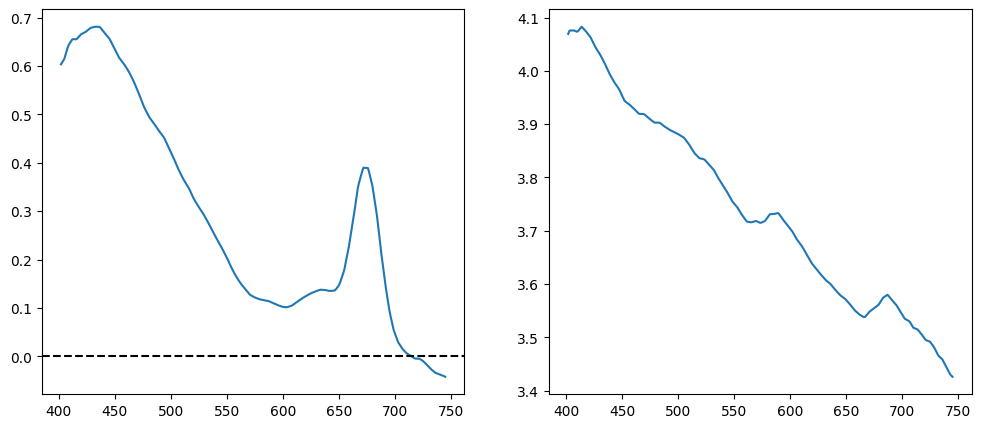

In [24]:
example_spectra = ds.sel(time = ds.time.values[1000])

fig, ax = plt.subplots(1,2,figsize = (12,5))

ax[0].plot(example_spectra.wavelength, example_spectra.a_mts_baseline)
ax[0].axhline(0, color = 'k', linestyle = '--')


ax[1].plot(example_spectra.wavelength, example_spectra.c_mts)

In [25]:
example_spectra

<xarray.Dataset> Size: 44kB
Dimensions:                         (wavelength: 344)
Coordinates:
    latitude                        float64 8B 44.63
    longitude                       float64 8B -123.7
    deployment                      int32 4B 13
    depth                           float64 8B 4.223
    time                            datetime64[ns] 8B 2019-06-24T17:00:07.008...
  * wavelength                      (wavelength) float64 3kB 402.0 ... 745.0
Data variables: (12/34)
    a_reference                     (wavelength) float64 3kB 619.5 ... 5.576e+03
    a_reference_dark_counts         float32 4B 472.0
    a_signal                        (wavelength) float64 3kB 408.5 ... 4.101e+03
    a_signal_dark                   float32 4B 729.0
    c_reference                     (wavelength) float64 3kB 678.8 ... 6.216e+03
    c_reference_dark                float32 4B 476.0
    ...                              ...
    c_mts                           (wavelength) float64 3kB 4.069 ... 3.426
    flag_gross_range_a_mts          (wavelength) float64 3kB 1.0 1.0 ... 1.0 1.0
    flag_gross_range_c_mts          (wavelength) float64 3kB 1.0 1.0 ... 1.0 1.0
    blanket_flag_gross_range_a_mts  float64 8B 1.0
    blanket_flag_gross_range_c_mts  float64 8B 1.0
    a_mts_baseline                  (wavelength) float64 3kB 0.6035 ... -0.04199
Attributes: (12/60)
    AssetManagementRecordLastModified:  2023-06-02T18:55:55.111000
    AssetUniqueID:                      CGINS-OPTAAJ-00138
    Conventions:                        CF-1.6
    Description:                        Spectrophotometer: OPTAA Series J
    FirmwareVersion:                    Not specified.
    Manufacturer:                       WET Labs
    ...                                 ...
    time_coverage_resolution:           P1.57S
    time_coverage_start:                2019-06-24T16:55:43.774000
    title:                              Data produced by Stream Engine versio...
    uuid:                               62529081-0c5a-42f1-a139-b717249fdf1e
    number_of_output_wavelengths:       86
    interpolation_step:                 1

## Split Into Profiles
OOI profiler data is not distributed to the end-user with a unique ID for each profile. Here, lets assume that the minimum time between profiles is 15 minutes.

In [26]:

def split_profiles(ds):
    """
    Split the data set into individual profiles, where each profile is a
    collection of data from a single deployment and profile sequence. The
    resulting data sets are returned in a list.

    :param ds: data set containing the profile data
    :return: a list of data sets, one for each profile
    """
    # split the data into profiles, assuming at least 120 seconds between profiles
    dt = ds.where(ds['time'].diff('time') > np.timedelta64(120, 's'), drop=True).get_index('time')

    # process each profile, adding the results to a list of profiles
    profiles = []
    jback = np.timedelta64(30, 's')  # 30 second jump back to avoid collecting data from the following profile
    for i, d in enumerate(dt):
        # pull out the profile
        if i == 0:
            profile = ds.sel(time=slice(ds['time'].values[0], d - jback))
        else:
            profile = ds.sel(time=slice(dt[i - 1], d - jback))

        # add the profile to the list
        profiles.append(profile)

    # grab the last profile and append it to the list
    profile = ds.sel(time=slice(d, ds['time'].values[-1]))
    profiles.append(profile)
    return profiles


def bin_profiles(profile, site_depth, bin_size=0.25):
    """
    Bin the data in the profile into a set of bins of a given size (default is
    25 cm). The bin depth is set to the center of the bin, using the median
    value of the data in each bin.

    :param profile: data set containing the profile data
    :param site_depth: maximum depth of the site, used to set binning range
    :param bin_size: size of the bin, in meters
    :return: a data set containing the binned data
    """
    # test the length of the profile, short ones with less than 15 records will be skipped
    if len(profile.time) < 15:
        return None

    # test the time range of the profile, short ones (less than 15 seconds) will be skipped
    if (profile.time[-1] - profile.time[0]).astype(float) / 10 ** 9 < 15:
        return None

    # use a set of median boxcar filters to help despike the data
    smth = profile.rolling(time=5, min_periods=3, center=True).median(keep_attrs=True).dropna("time", subset=['deployment'])
    smth = smth.rolling(time=5, min_periods=3, center=True).median(keep_attrs=True).dropna("time", subset=['deployment'])

    # bin the data using the center of the bin as the depth value
    bins = smth.groupby_bins('depth', np.arange(bin_size / 2, site_depth + bin_size / 2, bin_size))
    binning = []
    for grp in bins:
        avg = grp[1].mean('time', keepdims=True, keep_attrs=True)
        avg = avg.assign_coords({'time': np.atleast_1d(grp[1].time.mean().values)})  # add time back
        avg['depth'] = avg['depth'] * 0 + grp[0].mid  # set depth to bin midpoint
        binning += avg,  # append to the list

    binned = xr.concat(binning, 'time')
    return binned


In [27]:
profiles = split_profiles(ds)

In [31]:
p = profiles[-50]
pt = p.sel(wavelength = 660)

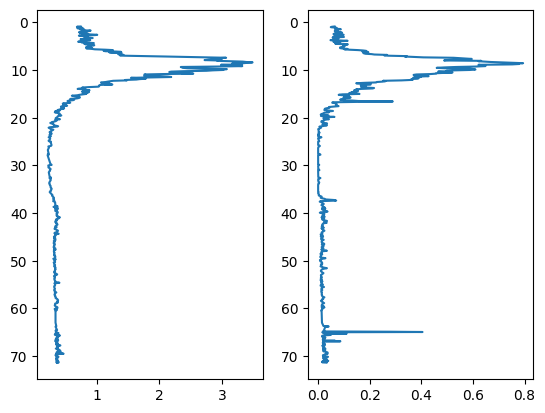

In [34]:
fig, ax = plt.subplots(1,2)

ax[0].plot(pt.c_mts, pt.depth)
ax[0].invert_yaxis()

ax[1].plot(pt.a_mts, pt.depth)
ax[1].invert_yaxis()